# PySpark for generating Levy Walks using KASI Clouds

> Using `scipy` and `pyspark`, we need to generate *Levy Walks* which partially mimic a cosmic halo distribution obtained from the HR4 simulation.

## Install basic packages for KASI Spark Cluster

In [11]:
#!pip3 install -U pip setuptools wheel

In [12]:
#!pip3 install -U numpy scipy pandas koalas pyarrow scikit-learn matplotlib astropy astroML

In [13]:
pip list |grep astro

astroML             0.4.1              
astropy             4.1                
You are using pip version 19.0, however version 21.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip list |grep pyarrow

pyarrow             5.0.0              
You are using pip version 19.0, however version 21.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Browse HDFS file systems 

#### Local file system

In [15]:
!pwd

/root/tempwork/examples


In [16]:
!ls

BreadBasket_DMS.csv				       start-jupyter-spark.sh
example-astronomy-pyspark-kasi-shong-standalone.ipynb


#### Hadoop File System (HDFS)

In [17]:
!hadoop fs -ls /data/examples

Found 1 items
-rw-r--r--   6 root supergroup     710518 2021-08-17 06:52 /data/examples/BreadBasket_DMS.csv


In [18]:
!hadoop fs -help

Usage: hadoop fs [generic options]
	[-appendToFile <localsrc> ... <dst>]
	[-cat [-ignoreCrc] <src> ...]
	[-checksum <src> ...]
	[-chgrp [-R] GROUP PATH...]
	[-chmod [-R] <MODE[,MODE]... | OCTALMODE> PATH...]
	[-chown [-R] [OWNER][:[GROUP]] PATH...]
	[-copyFromLocal [-f] [-p] [-l] [-d] [-t <thread count>] <localsrc> ... <dst>]
	[-copyToLocal [-f] [-p] [-ignoreCrc] [-crc] <src> ... <localdst>]
	[-count [-q] [-h] [-v] [-t [<storage type>]] [-u] [-x] [-e] <path> ...]
	[-cp [-f] [-p | -p[topax]] [-d] <src> ... <dst>]
	[-createSnapshot <snapshotDir> [<snapshotName>]]
	[-deleteSnapshot <snapshotDir> <snapshotName>]
	[-df [-h] [<path> ...]]
	[-du [-s] [-h] [-v] [-x] <path> ...]
	[-expunge [-immediate]]
	[-find <path> ... <expression> ...]
	[-get [-f] [-p] [-ignoreCrc] [-crc] <src> ... <localdst>]
	[-getfacl [-R] <path>]
	[-getfattr [-R] {-n name | -d} [-e en] <path>]
	[-getmerge [-nl] [-skip-empty-file] <src> <localdst>]
	[-head <file>]
	[-help [cmd ...]]
	[-ls [-C] [-d] [-h] [-q] [-R] [-t] [-

## Import Basic Libraries

In [19]:
# generate edges 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [20]:
import pyarrow.parquet as pq

In [21]:
# Basic PySpark Libraries


from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

spark = SparkSession \
        .builder \
        .appName('pyspark-app') \
        .getOrCreate()

sc = spark.sparkContext
sqlsc = SQLContext(sc)
#sc.setCheckpointDir("hdfs://master:54310/tmp/spark/checkpoints")
#sc.setCheckpointDir("./checkpoints") # local file system yet; no hdfs

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

#spark.conf.set("ARROW_PRE_0_15_IPC_FORMAT","1") #pyarrow 0.15.x need this option
#spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [22]:
#sc.getConf().getAll()

In [23]:
# Enable Arrow for boosting up python performances 
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark.conf.set('spark.debug.maxToStringFields',50)

In [24]:
sc.getConf().getAll()

[('spark.app.id', 'app-20210818075414-0002'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.driver.host', 'spark-large-master'),
 ('spark.app.startTime', '1629273253689'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.master', 'spark://spark-large-master:7077'),
 ('spark.driver.port', '41945'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.sql.warehouse.dir', 'file:/root/tempwork/examples/spark-warehouse')]

## Tutorial Getting Pi

In [25]:
from random import random
from operator import add

In [26]:
partitions = 5
n = 1000000 * partitions

In [27]:
def f(_):
    x = np.random.rand() * 2.0 - 1.0
    y = np.random.rand() * 2.0 - 1.0
    return 1 if x ** 2 + y ** 2 <= 1.0 else 0

In [28]:
%%time
count = sc.parallelize(range(1, n + 1), partitions).map(f).reduce(add)
print("Pi is roughly %.20f" % (4.0 * count / n))

Pi is roughly 3.14135359999999996816
CPU times: user 19 ms, sys: 0 ns, total: 19 ms
Wall time: 2.92 s


## Reading data from the KASI Object Storage

In [29]:
'''
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", "shongscience")
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "shongscience!@#")
sc._jsc.hadoopConfiguration().set("fs.s3a.proxy.host", "minio-service")
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "minio")
sc._jsc.hadoopConfiguration().set("fs.s3a.proxy.port", "9000")
sc._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")
sc._jsc.hadoopConfiguration().set("fs.s3a.connection.ssl.enabled", "false")
sc._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
'''

'\nsc._jsc.hadoopConfiguration().set("fs.s3a.access.key", "shongscience")\nsc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "shongscience!@#")\nsc._jsc.hadoopConfiguration().set("fs.s3a.proxy.host", "minio-service")\nsc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "minio")\nsc._jsc.hadoopConfiguration().set("fs.s3a.proxy.port", "9000")\nsc._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")\nsc._jsc.hadoopConfiguration().set("fs.s3a.connection.ssl.enabled", "false")\nsc._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")\n'

In [30]:
#sc.setCheckpointDir("s3a://tmp/checkpoints")

In [31]:
# for accessing to S3 of AWS
#sc._jsc.hadoopConfiguration().set("fs.s3a.access.key","your-access-key")
#sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key","your-secret-key")

In [32]:
'''
df = spark.read \
    .format('csv') \
    .option('header','true') \
    .load('s3a://shongdata/BreadBasket_DMS.csv', schema=bakery_schema)
'''

"\ndf = spark.read     .format('csv')     .option('header','true')     .load('s3a://shongdata/BreadBasket_DMS.csv', schema=bakery_schema)\n"

## Reading data from HDFS at `spark-large-master`

In [33]:
sc.setCheckpointDir("hdfs://spark-large-master:54310/checkpoints")

In [34]:
bakery_schema = T.StructType([
    T.StructField('date', T.StringType(), True),
    T.StructField('time', T.StringType(), True),
    T.StructField('transaction', T.IntegerType(), True),
    T.StructField('item', T.StringType(), True)
])

In [35]:
df = spark.read \
    .format('csv') \
    .option('header','true') \
    .load('hdfs://spark-large-master:54310/data/examples/BreadBasket_DMS.csv', schema=bakery_schema)

In [36]:
%%time
df.show(10)

+----------+--------+-----------+-------------+
|      date|    time|transaction|         item|
+----------+--------+-----------+-------------+
|2016-10-30|09:58:11|          1|        Bread|
|2016-10-30|10:05:34|          2| Scandinavian|
|2016-10-30|10:05:34|          2| Scandinavian|
|2016-10-30|10:07:57|          3|Hot chocolate|
|2016-10-30|10:07:57|          3|          Jam|
|2016-10-30|10:07:57|          3|      Cookies|
|2016-10-30|10:08:41|          4|       Muffin|
|2016-10-30|10:13:03|          5|       Coffee|
|2016-10-30|10:13:03|          5|       Pastry|
|2016-10-30|10:13:03|          5|        Bread|
+----------+--------+-----------+-------------+
only showing top 10 rows

CPU times: user 1.18 ms, sys: 0 ns, total: 1.18 ms
Wall time: 2.44 s


In [37]:
%%time
df.describe().show()

+-------+----------+--------+------------------+----------------+
|summary|      date|    time|       transaction|            item|
+-------+----------+--------+------------------+----------------+
|  count|     21293|   21293|             21293|           21293|
|   mean|      null|    null| 4951.990889024562|            null|
| stddev|      null|    null|2787.7583996983885|            null|
|    min|2016-10-30|01:21:05|                 1|      Adjustment|
|    max|2017-04-09|23:38:41|              9684|Victorian Sponge|
+-------+----------+--------+------------------+----------------+

CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 4.15 s


## Testing Levy Walks

In [38]:
from scipy.stats import uniform

In [39]:
def levy_periodic(rzero,inpow,x,y,z,sysL=1.0):
    # 3-D Levy Walks
    tmppi = uniform.rvs(loc=0.0,scale=2.*np.pi)
    tmpcos = 2.0*uniform.rvs() - 1.0
    tmpsin = np.sqrt(1.0 - tmpcos*tmpcos)  
    tmpl = rzero * np.power(uniform.rvs(), -1.0/inpow)
    
    nx = x + tmpl * tmpsin * np.cos(tmppi)
    ny = y + tmpl * tmpsin * np.sin(tmppi)
    nz = z + tmpl * tmpcos
    
    #print(x,y,z,nx,ny,nz)
    
    # Periodic Boundary
    if nx >= sysL:
        nx = nx - sysL * np.floor(nx/sysL)
    if ny >= sysL:
        ny = ny - sysL * np.floor(ny/sysL)
    if nz >= sysL:
        nz = nz - sysL * np.floor(nz/sysL)
    
    if nx < 0.0:
        nx = nx + sysL * (1.0 + np.floor(np.abs(nx)/sysL))
    if ny < 0.0:
        ny = ny + sysL * (1.0 + np.floor(np.abs(ny)/sysL))
    if nz < 0.0:
        nz = nz + sysL * (1.0 + np.floor(np.abs(nz)/sysL))
        
    return np.double([nx,ny,nz,tmpl])

In [40]:
# test the first Levy Walk
levy_periodic(1.0,1.2,0.0,0.0,0.0,sysL=100)

array([9.92625366e+01, 9.90812901e+01, 8.73671157e-02, 1.18131838e+00])

In [41]:
levy_periodic(1.0,1.2,0.5,0.5,0.5,sysL=1.0)

array([0.58521417, 0.36522394, 0.5845061 , 1.09681159])

In [42]:
xlv = []
ylv = []
zlv = []
llv = []
numlv = 2000

walker = np.double([0.5,0.5,0.5,0.5])

#xlv.append(walker[0])
#ylv.append(walker[1])
#zlv.append(walker[2])
#llv.append(walker[3])
for i in range(numlv):
    walker = levy_periodic(0.01,1.2,walker[0],walker[1],walker[2],sysL=1.0)
    xlv.append(walker[0])
    ylv.append(walker[1])
    zlv.append(walker[2])
    llv.append(walker[3])

## Measuring Two-point Functions

In [43]:
from astroML.correlation import two_point

In [44]:
Xlv = np.stack([xlv,ylv,zlv],axis=1)

In [45]:
bins, binstep = np.linspace(np.log10(0.005), np.log10(1.0), 25, retstep=True)

In [46]:
xbins = bins[1:] - binstep*0.5
xbins = np.power(10,xbins)

In [47]:
bins = np.power(10,bins)

In [48]:
corr = two_point(Xlv, bins)

In [49]:
corr.shape

(24,)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


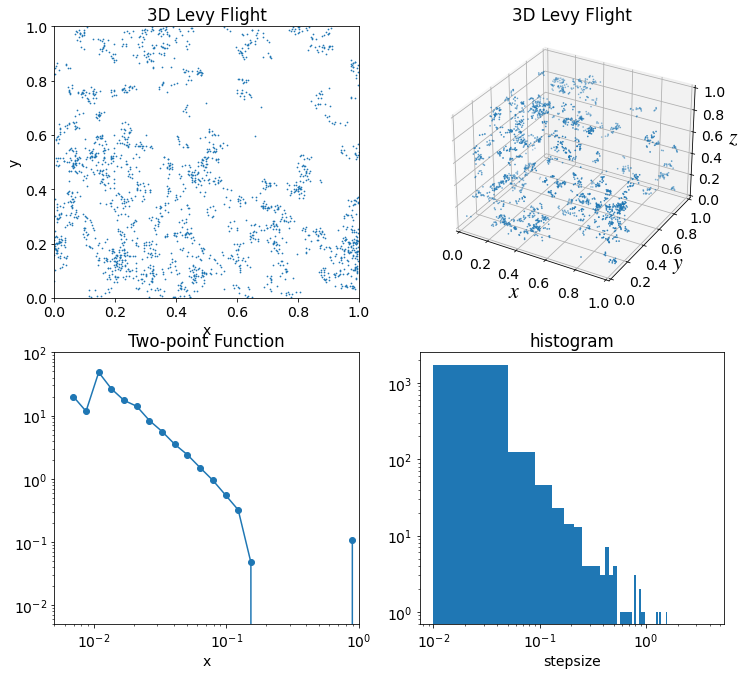

In [50]:
from mpl_toolkits.mplot3d import Axes3D


# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 14})
plt.rcParams['mathtext.fontset'] = 'stix'

# initialize figure
fig = plt.figure( figsize=(12,11) )

# plot 2D random walk with Levy stepsize
plt.subplot(221)
plt.axis([0,1,0,1])
plt.scatter( xlv, ylv, s=0.5 )
plt.xlabel( 'x' )
plt.ylabel( 'y' )
plt.title(r'3D Levy Flight' )

ax = fig.add_subplot(222, projection='3d')
ax.set_title(r'3D Levy Flight')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.scatter(xlv,ylv,zlv,s=0.5)
ax.set_xlabel(r'$x$',fontsize=22)
ax.set_ylabel(r'$y$',fontsize=22)
ax.set_zlabel(r'$z$',fontsize=22)

# plot histogram
plt.subplot(223)

plt.axis([0.005,1,0.005,100])
plt.yscale( 'log' )
plt.xscale( 'log' )
plt.xlabel( 'x' )
plt.title( 'Two-point Function' )
plt.scatter(xbins,corr)
plt.plot(xbins,corr)

# plot histogram
plt.subplot(224)
#num_bins = n/10
plt.hist( llv, bins=100 )
plt.yscale( 'log' )
plt.xscale( 'log' )
plt.xlabel( 'stepsize' )
plt.title( 'histogram' )

plt.show()

> 20000 training sample and 7000 testing sample 

In [51]:
pwd

'/root/tempwork/examples'